**Key Ideas**

- Explore how changes in beta influence changes in S, I and R in the SIRS model
- Explore different timings and initiations of lockdowns
- Maybe have a look at the facemask study
- See if I can implement R0 into this

## Basic SIR Model

This is a basic SIR model which assumes that when someone recovers. they gain immunity forever.

By changing the beta values, this could represent lockdowns / face masks.

A reduction in beta reduces transmission. Beta is a value that represents a (contact rate) and p (probability of transmission) and therefore reducing beta would reduce the amount of people getting infected

R0 is commonly referred to in the literature. This is basically the beta / gamma and refers to the amount of people one person would infect. So as beta decreases, the R0 would decrease. 

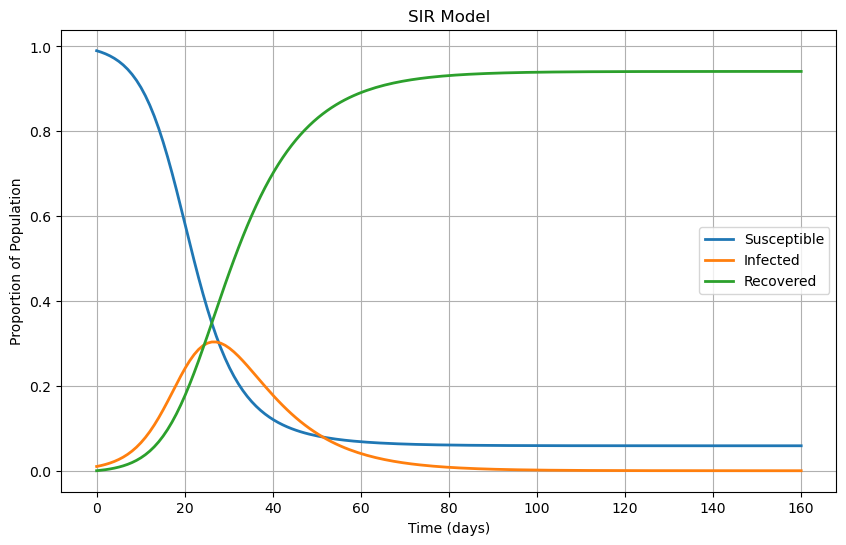

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

# Parameters
beta = 0.3  # Infection rate
gamma = 0.1  # Recovery rate

# Initial conditions
S0 = 0.99  # Initial fraction of the population that is susceptible
I0 = 0.01  # Initial fraction of the population that is infected
R0 = 0.0   # Initial fraction of the population that is recovered
initial_conditions = [S0, I0, R0]

# Time points (days)
t = np.linspace(0, 160, 160)

# SIR model differential equations
def sir_model(y, t, beta, gamma):
    S, I, R = y
    dS_dt = -beta * S * I
    dI_dt = beta * S * I - gamma * I
    dR_dt = gamma * I
    return [dS_dt, dI_dt, dR_dt]

# Solve the differential equations
solution = odeint(sir_model, initial_conditions, t, args=(beta, gamma))
S, I, R = solution.T

# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(t, S, label='Susceptible', linewidth=2)
plt.plot(t, I, label='Infected', linewidth=2)
plt.plot(t, R, label='Recovered', linewidth=2)
plt.xlabel('Time (days)')
plt.ylabel('Proportion of Population')
plt.title('SIR Model')
plt.legend()
plt.grid(True)
plt.show()


## SIRS Model

In this model, some of the recovered population do not gain immunity. 

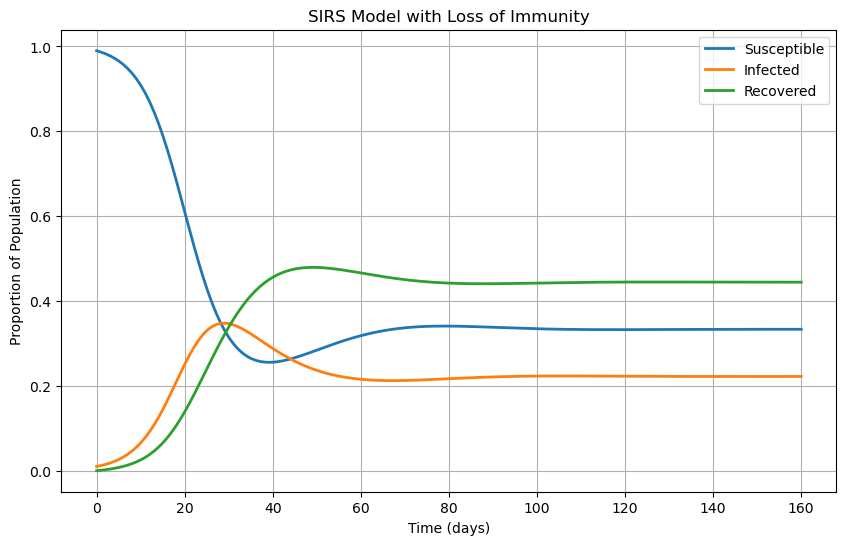

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

# Parameters
beta = 0.3    # Infection rate
gamma = 0.1   # Recovery rate
delta = 0.05  # Rate of loss of immunity

# Initial conditions
S0 = 0.99     # Initial fraction of susceptible population
I0 = 0.01     # Initial fraction of infected population
R0 = 0.0      # Initial fraction of recovered population
initial_conditions = [S0, I0, R0]

# Time points (days)
t = np.linspace(0, 160, 160)

# SIRS model differential equations
def sirs_model(y, t, beta, gamma, delta):
    S, I, R = y
    dS_dt = -beta * S * I + delta * R  # Susceptibles increase as immunity wanes
    dI_dt = beta * S * I - gamma * I   # Infected individuals
    dR_dt = gamma * I - delta * R      # Recovered individuals lose immunity over time
    return [dS_dt, dI_dt, dR_dt]

# Solve the differential equations
solution = odeint(sirs_model, initial_conditions, t, args=(beta, gamma, delta))
S, I, R = solution.T

# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(t, S, label='Susceptible', linewidth=2)
plt.plot(t, I, label='Infected', linewidth=2)
plt.plot(t, R, label='Recovered', linewidth=2)
plt.xlabel('Time (days)')
plt.ylabel('Proportion of Population')
plt.title('SIRS Model with Loss of Immunity')
plt.legend()
plt.grid(True)
plt.show()


**Testing different beta values in for SIRS model**

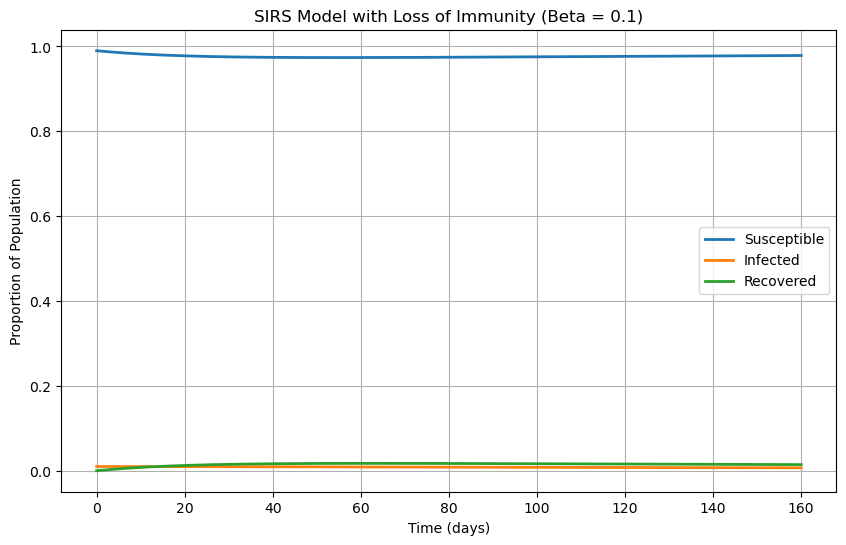

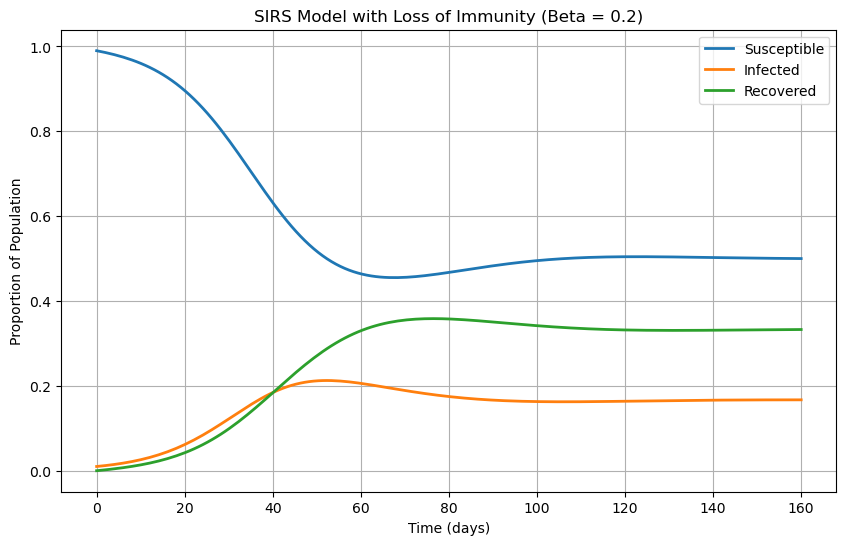

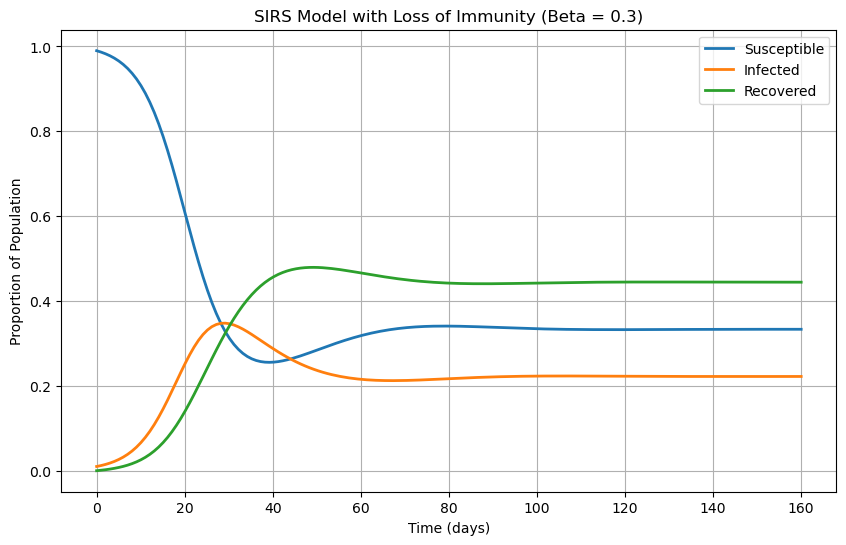

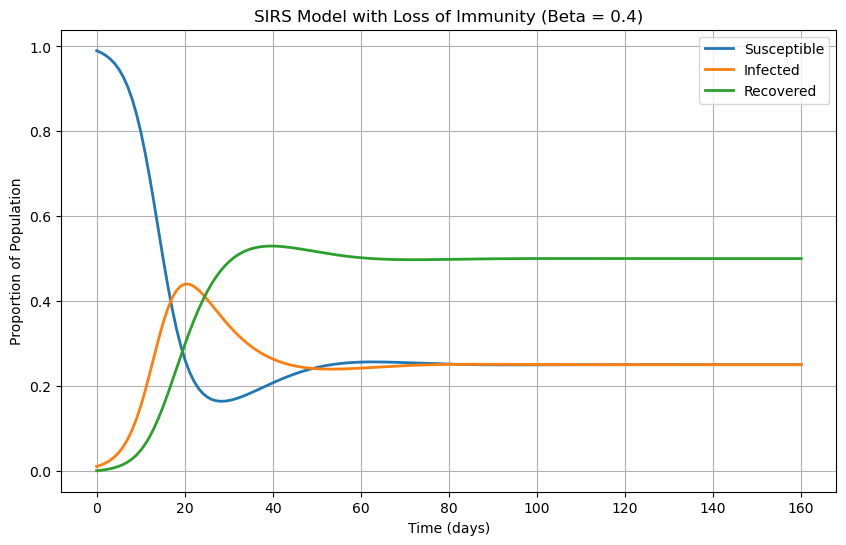

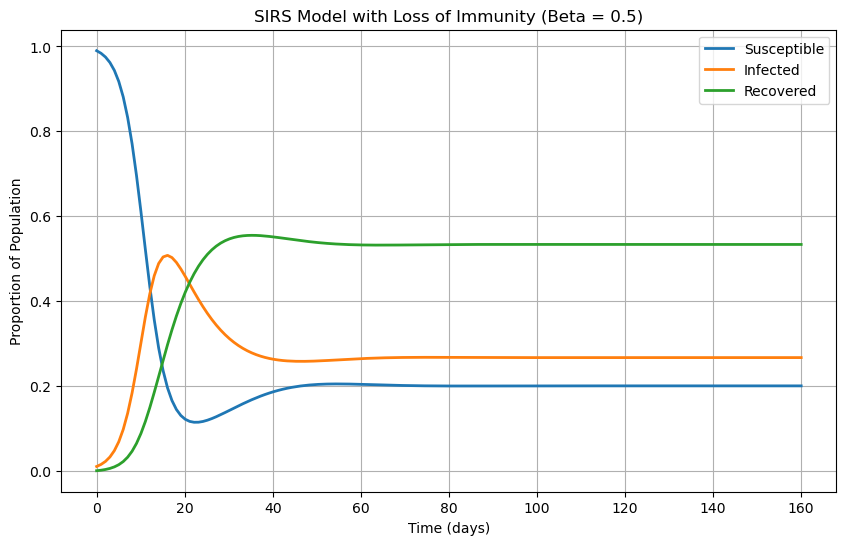

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

# Parameters
gamma = 0.1   # Recovery rate
delta = 0.05  # Rate of loss of immunity
beta_values = [0.1, 0.2, 0.3, 0.4, 0.5]  # Different infection rates to test

# Initial conditions
S0 = 0.99     # Initial fraction of susceptible population
I0 = 0.01     # Initial fraction of infected population
R0 = 0.0      # Initial fraction of recovered population
initial_conditions = [S0, I0, R0]

# Time points (days)
t = np.linspace(0, 160, 160)

# SIRS model differential equations
def sirs_model(y, t, beta, gamma, delta):
    S, I, R = y
    dS_dt = -beta * S * I + delta * R  # Susceptibles increase as immunity wanes
    dI_dt = beta * S * I - gamma * I   # Infected individuals
    dR_dt = gamma * I - delta * R      # Recovered individuals lose immunity over time
    return [dS_dt, dI_dt, dR_dt]

# Loop through each beta value and plot the results
for beta in beta_values:
    # Solve the differential equations for the current beta value
    solution = odeint(sirs_model, initial_conditions, t, args=(beta, gamma, delta))
    S, I, R = solution.T

    # Plotting the results
    plt.figure(figsize=(10, 6))
    plt.plot(t, S, label='Susceptible', linewidth=2)
    plt.plot(t, I, label='Infected', linewidth=2)
    plt.plot(t, R, label='Recovered', linewidth=2)
    plt.xlabel('Time (days)')
    plt.ylabel('Proportion of Population')
    plt.title(f'SIRS Model with Loss of Immunity (Beta = {beta})')
    plt.legend()
    plt.grid(True)
    plt.show()


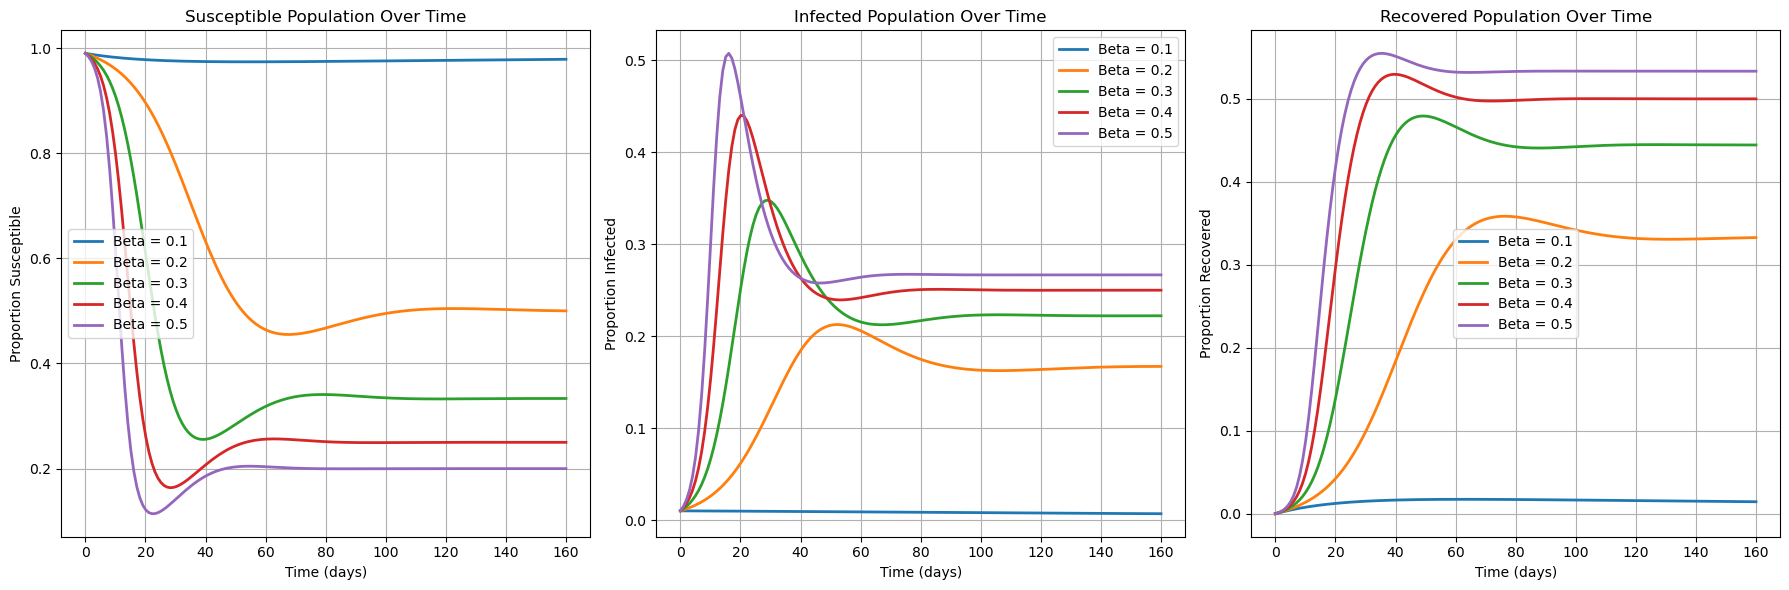

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

# Parameters
gamma = 0.1   # Recovery rate
delta = 0.05  # Rate of loss of immunity
beta_values = [0.1, 0.2, 0.3, 0.4, 0.5]  # Different infection rates to test

# Initial conditions
S0 = 0.99     # Initial fraction of susceptible population
I0 = 0.01     # Initial fraction of infected population
R0 = 0.0      # Initial fraction of recovered population
initial_conditions = [S0, I0, R0]

# Time points (days)
t = np.linspace(0, 160, 160)

# Store results for each beta value
S_results = []
I_results = []
R_results = []

# SIRS model differential equations
def sirs_model(y, t, beta, gamma, delta):
    S, I, R = y
    dS_dt = -beta * S * I + delta * R  # Susceptibles increase as immunity wanes
    dI_dt = beta * S * I - gamma * I   # Infected individuals
    dR_dt = gamma * I - delta * R      # Recovered individuals lose immunity over time
    return [dS_dt, dI_dt, dR_dt]

# Solve the model for each beta and store results
for beta in beta_values:
    solution = odeint(sirs_model, initial_conditions, t, args=(beta, gamma, delta))
    S, I, R = solution.T
    S_results.append(S)
    I_results.append(I)
    R_results.append(R)

# Plotting all susceptibles, infecteds, and recovereds on separate graphs
plt.figure(figsize=(18, 6))

# Susceptible plot
plt.subplot(1, 3, 1)
for i, beta in enumerate(beta_values):
    plt.plot(t, S_results[i], label=f'Beta = {beta}', linewidth=2)
plt.xlabel('Time (days)')
plt.ylabel('Proportion Susceptible')
plt.title('Susceptible Population Over Time')
plt.legend()
plt.grid(True)

# Infected plot
plt.subplot(1, 3, 2)
for i, beta in enumerate(beta_values):
    plt.plot(t, I_results[i], label=f'Beta = {beta}', linewidth=2)
plt.xlabel('Time (days)')
plt.ylabel('Proportion Infected')
plt.title('Infected Population Over Time')
plt.legend()
plt.grid(True)

# Recovered plot
plt.subplot(1, 3, 3)
for i, beta in enumerate(beta_values):
    plt.plot(t, R_results[i], label=f'Beta = {beta}', linewidth=2)
plt.xlabel('Time (days)')
plt.ylabel('Proportion Recovered')
plt.title('Recovered Population Over Time')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


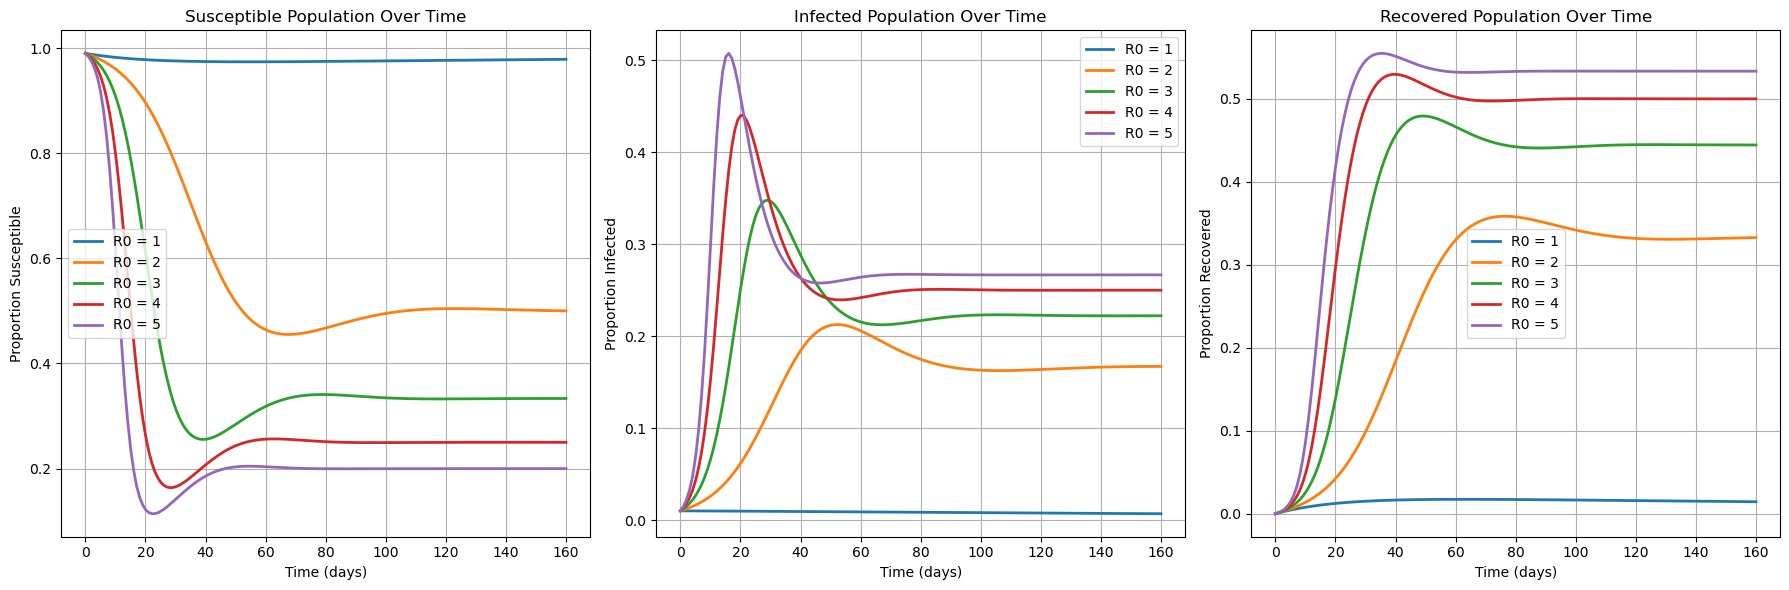

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

# Parameters
gamma = 0.1    # Recovery rate
delta = 0.05   # Rate of loss of immunity
R0_values = [1, 2, 3, 4, 5]  # Different R0 values to test

# Convert R0 values to corresponding beta values
beta_values = [R0 * gamma for R0 in R0_values]

# Initial conditions
S0 = 0.99      # Initial fraction of susceptible population
I0 = 0.01      # Initial fraction of infected population
R0_init = 0.0  # Initial fraction of recovered population
initial_conditions = [S0, I0, R0_init]

# Time points (days)
t = np.linspace(0, 160, 160)

# Store results for each R0 value
S_results = []
I_results = []
R_results = []

# SIRS model differential equations
def sirs_model(y, t, beta, gamma, delta):
    S, I, R = y
    dS_dt = -beta * S * I + delta * R  # Susceptibles increase as immunity wanes
    dI_dt = beta * S * I - gamma * I   # Infected individuals
    dR_dt = gamma * I - delta * R      # Recovered individuals lose immunity over time
    return [dS_dt, dI_dt, dR_dt]

# Solve the model for each beta (calculated from R0) and store results
for beta in beta_values:
    solution = odeint(sirs_model, initial_conditions, t, args=(beta, gamma, delta))
    S, I, R = solution.T
    S_results.append(S)
    I_results.append(I)
    R_results.append(R)

# Plotting all susceptibles, infecteds, and recovereds on separate graphs
plt.figure(figsize=(18, 6))

# Susceptible plot
plt.subplot(1, 3, 1)
for i, R0 in enumerate(R0_values):
    plt.plot(t, S_results[i], label=f'R0 = {R0}', linewidth=2)
plt.xlabel('Time (days)')
plt.ylabel('Proportion Susceptible')
plt.title('Susceptible Population Over Time')
plt.legend()
plt.grid(True)

# Infected plot
plt.subplot(1, 3, 2)
for i, R0 in enumerate(R0_values):
    plt.plot(t, I_results[i], label=f'R0 = {R0}', linewidth=2)
plt.xlabel('Time (days)')
plt.ylabel('Proportion Infected')
plt.title('Infected Population Over Time')
plt.legend()
plt.grid(True)

# Recovered plot
plt.subplot(1, 3, 3)
for i, R0 in enumerate(R0_values):
    plt.plot(t, R_results[i], label=f'R0 = {R0}', linewidth=2)
plt.xlabel('Time (days)')
plt.ylabel('Proportion Recovered')
plt.title('Recovered Population Over Time')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


## Exploring the effect of facemasks - effectiveness and % of population

This is in line with Section 1 of the Stutt paper 

This is not an SIRS model but purely a way to calculate Re (infection rate for an individual) when taking into account mask effectiveness and % of the population wearing a mask

AttributeError: 'Colorbar' object has no attribute 'set_clim'

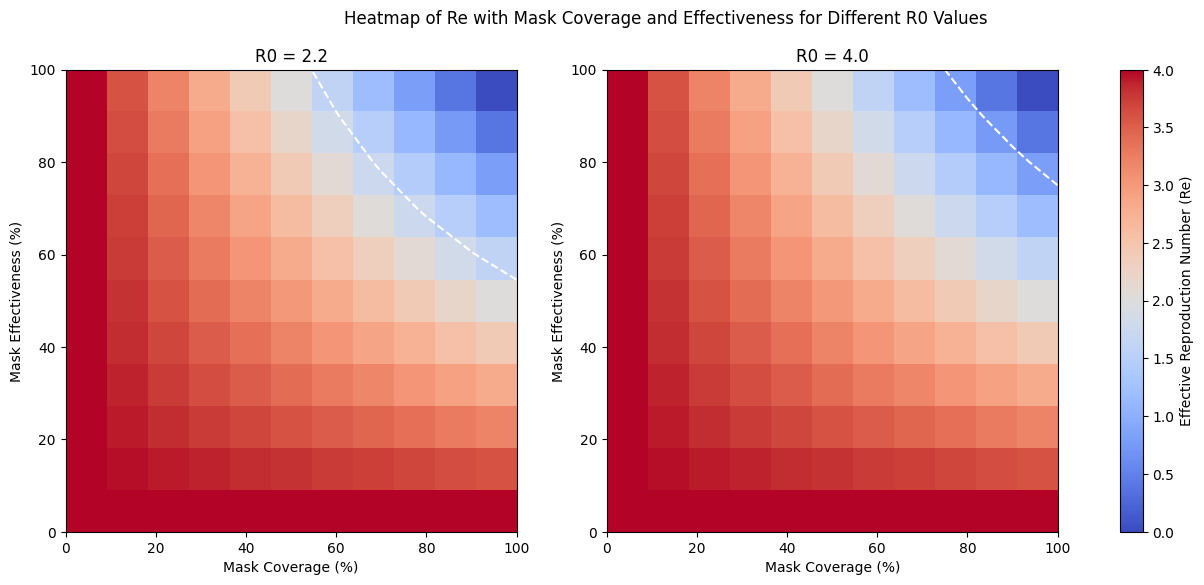

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters for both scenarios
R0_values = [2.2, 4.0]  # Different R0 scenarios
mask_coverage_range = np.linspace(0, 1, 11)  # 0% to 100% in steps of 10%
mask_effectiveness_range = np.linspace(0, 1, 11)  # 0% to 100% in steps of 10%

# Create a subplot with side-by-side heatmaps
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle("Heatmap of Re with Mask Coverage and Effectiveness for Different R0 Values")

for idx, R0 in enumerate(R0_values):
    # Initialize matrix to store Re values
    Re_values = np.zeros((len(mask_coverage_range), len(mask_effectiveness_range)))

    # Calculate Re for each combination of mask coverage and effectiveness
    for i, mask_coverage in enumerate(mask_coverage_range):
        for j, mask_effectiveness in enumerate(mask_effectiveness_range):
            # Adjusted reproduction number, Re
            Re = R0 * (1 - mask_coverage * mask_effectiveness)
            Re_values[i, j] = Re

    # Plot heatmap
    im = axes[idx].imshow(Re_values, extent=[0, 100, 0, 100], origin='lower', aspect='auto', cmap='coolwarm')
    axes[idx].set_title(f"R0 = {R0}")
    axes[idx].set_xlabel("Mask Coverage (%)")
    axes[idx].set_ylabel("Mask Effectiveness (%)")
    axes[idx].set_aspect('auto')

    # Add contour for Re < 1 region
    contour = axes[idx].contour(mask_coverage_range * 100, mask_effectiveness_range * 100, Re_values, 
                                levels=[1], colors='white', linestyles='--')
    
# Add color bar
cbar = fig.colorbar(im, ax=axes.ravel().tolist(), label="Effective Reproduction Number (Re)")
cbar.set_clim(0, max(R0_values))  # Set color limits to the maximum R0 for clarity

plt.show()


The dotted line shows where Re = 1 and therefore the virus is no longer considered endemic

## Various facemask effectiveness' and systematic lockdowns

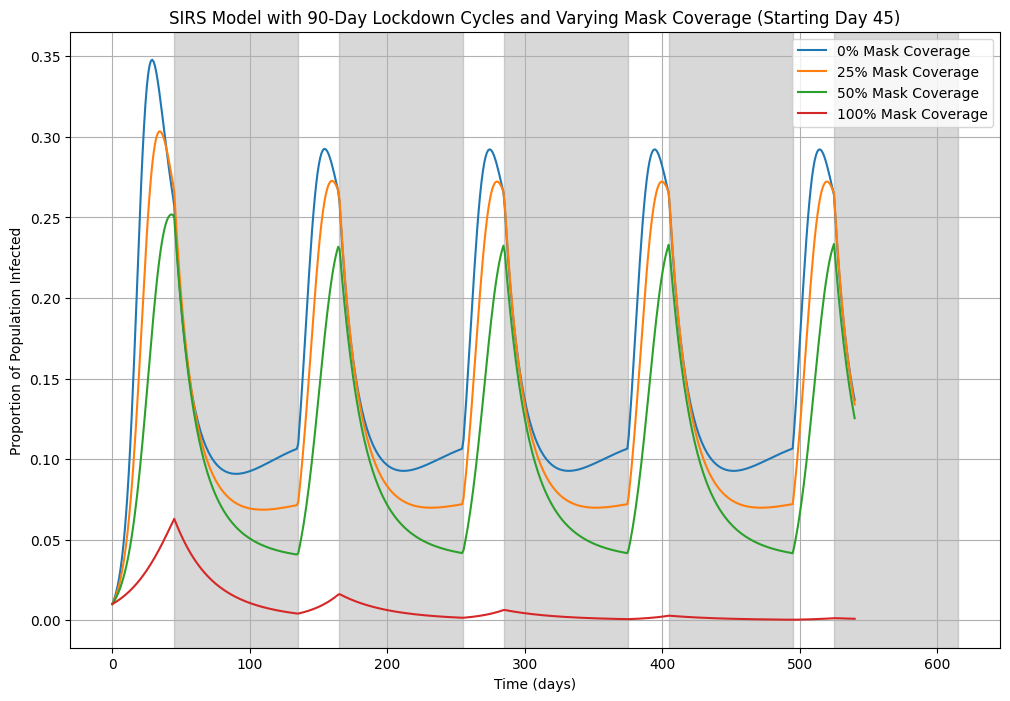

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

# Parameters
R0_base = 3.0               # Basic reproduction number without intervention
gamma = 0.1                 # Recovery rate
delta = 0.05                # Rate of immunity loss
mask_effectiveness = 0.5    # Masks reduce transmission by 50%
lockdown_reduction = 0.5    # 50% reduction in transmission during lockdown
lockdown_duration = 90      # Lockdown period in days
off_duration = 30           # Period without lockdown in days
total_days = 540            # Total simulation period in days (18 months)

# Define mask-wearing population percentages
mask_coverage_percentages = [0, 0.25, 0.5, 1.0]

# Base infection rate (beta) calculated from R0 and gamma
beta_base = R0_base * gamma

# First lockdown start day
first_lockdown_start = 45

# Lockdown function to check if a given day is in lockdown, starting the first lockdown on day 45
def is_in_lockdown(day):
    # Adjust day relative to the first lockdown start
    day_adjusted = day - first_lockdown_start
    if day_adjusted < 0:
        return False  # No lockdown before the first start day
    cycle_length = lockdown_duration + off_duration
    day_in_cycle = day_adjusted % cycle_length
    return day_in_cycle < lockdown_duration

# Time points (days)
t = np.linspace(0, total_days, total_days)

# SIRS model differential equations with time-dependent infection rate
def sirs_model(y, t, gamma, delta, mask_coverage):
    S, I, R = y
    # Adjust the infection rate based on mask coverage
    beta = beta_base * (1 - mask_coverage * mask_effectiveness)
    # Apply lockdown reduction if within lockdown period
    if is_in_lockdown(t):
        beta *= lockdown_reduction
    # SIRS equations
    dS_dt = -beta * S * I + delta * R      # Susceptible equation
    dI_dt = beta * S * I - gamma * I       # Infected equation
    dR_dt = gamma * I - delta * R          # Recovered equation
    return [dS_dt, dI_dt, dR_dt]

# Plotting setup
plt.figure(figsize=(12, 8))

# Run the model for each mask coverage percentage and plot results
for mask_coverage in mask_coverage_percentages:
    # Initial conditions for each run
    S0 = 0.99      # Initial susceptible fraction
    I0 = 0.01      # Initial infected fraction
    R0 = 0.0       # Initial recovered fraction
    initial_conditions = [S0, I0, R0]
    
    # Solve the differential equations
    solution = odeint(sirs_model, initial_conditions, t, args=(gamma, delta, mask_coverage))
    S, I, R = solution.T

    # Plot results for Infected
    plt.plot(t, I, label=f'{int(mask_coverage * 100)}% Mask Coverage')

# Highlight lockdown periods in grey
cycle_length = lockdown_duration + off_duration
for cycle_start in range(first_lockdown_start, total_days, cycle_length):
    plt.axvspan(cycle_start, cycle_start + lockdown_duration, color='gray', alpha=0.3)

# Finalize plot
plt.xlabel('Time (days)')
plt.ylabel('Proportion of Population Infected')
plt.title(f'SIRS Model with 90-Day Lockdown Cycles and Varying Mask Coverage (Starting Day 45)')
plt.legend()
plt.grid(True)
plt.show()


## Mask wearing on day 30, 60, 90 and 120 for 100% of the population

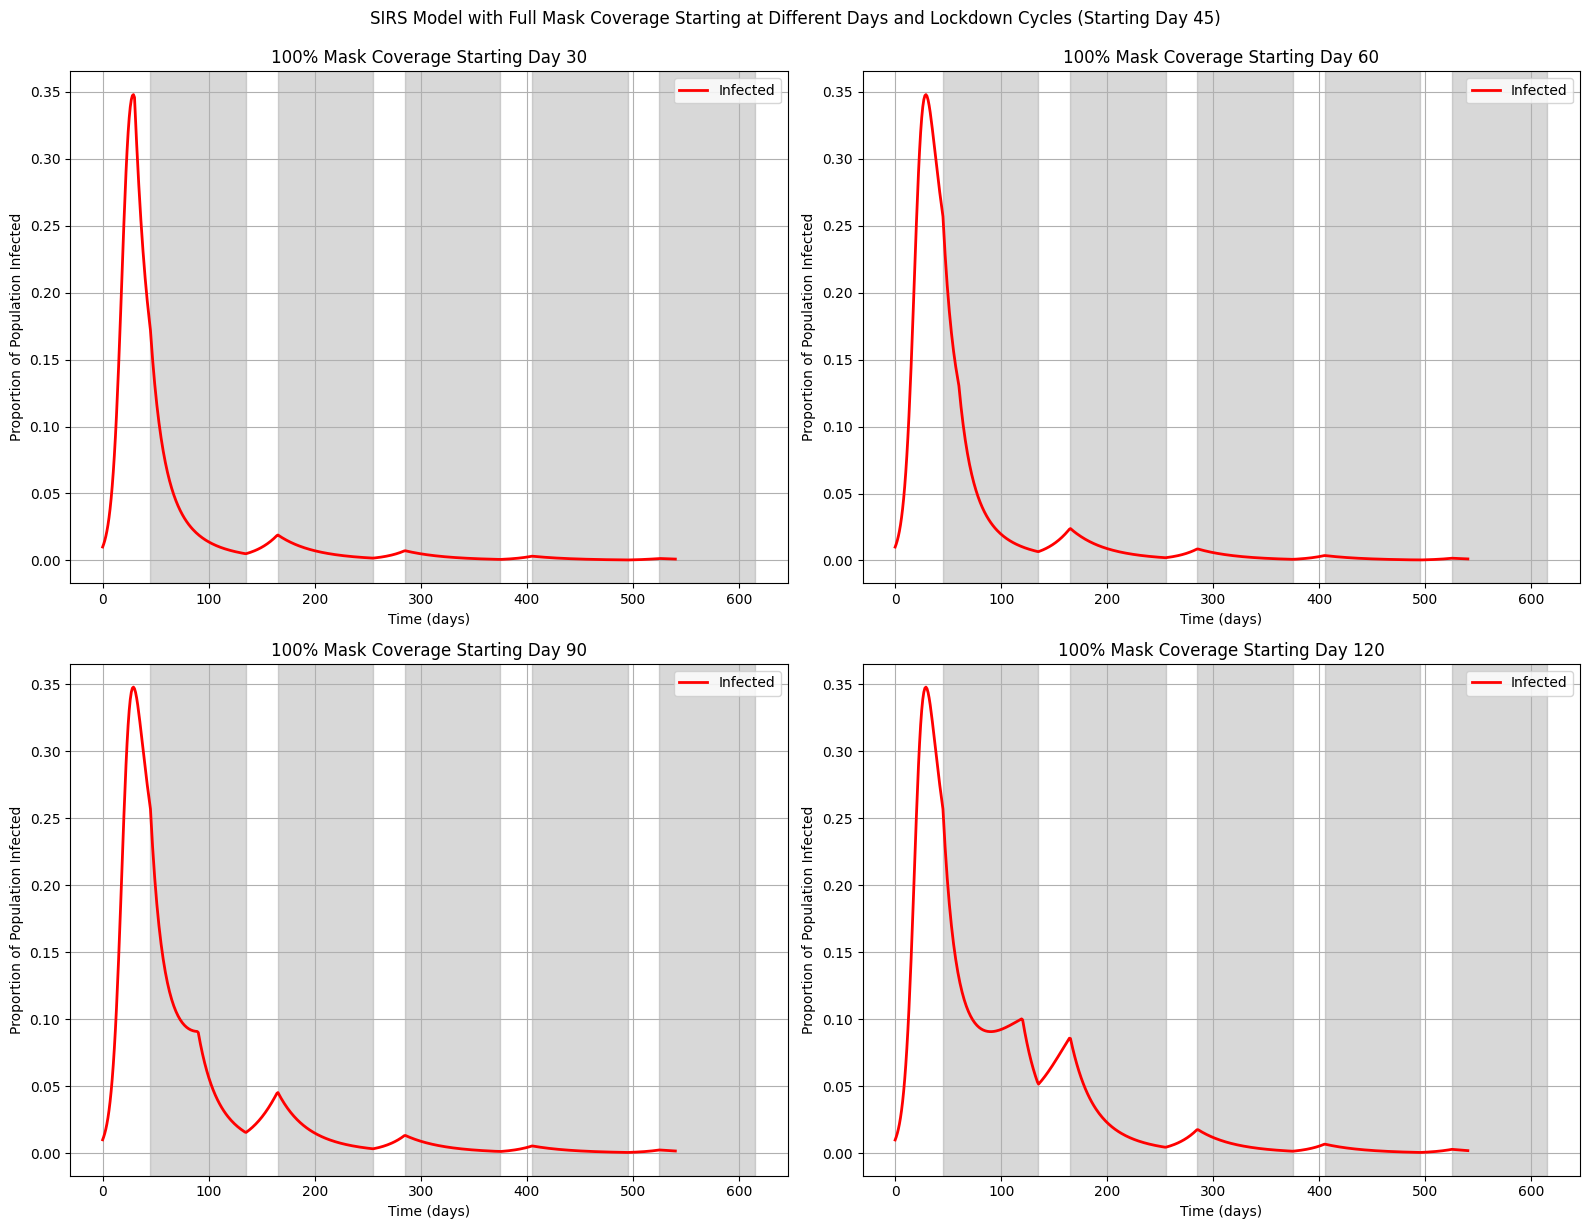

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

# Parameters
R0_base = 3.0               # Basic reproduction number without intervention
gamma = 0.1                 # Recovery rate
delta = 0.05                # Rate of immunity loss
mask_effectiveness = 0.5    # Masks reduce transmission by 50%
lockdown_reduction = 0.5    # 50% reduction in transmission during lockdown
lockdown_duration = 90      # Lockdown period in days
off_duration = 30           # Period without lockdown in days
total_days = 540            # Total simulation period in days (18 months)

# Define the days on which 100% mask coverage starts
mask_start_days = [30, 60, 90, 120]

# Base infection rate (beta) calculated from R0 and gamma
beta_base = R0_base * gamma

# Function to check if a given day is in a lockdown period, starting the first lockdown on day 45
first_lockdown_start = 45  # First lockdown starts on day 45

def is_in_lockdown(day):
    # Calculate day in adjusted cycle based on starting lockdown at day 45
    day_adjusted = day - first_lockdown_start
    if day_adjusted < 0:
        return False  # No lockdown before the first start day
    cycle_length = lockdown_duration + off_duration
    day_in_cycle = day_adjusted % cycle_length
    return day_in_cycle < lockdown_duration

# Time points (days)
t = np.linspace(0, total_days, total_days)

# Plotting setup with four separate graphs for each phase of mask implementation
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.ravel()  # Flatten for easy indexing

# Titles for each subplot to indicate mask coverage start day
mask_titles = {
    30: "100% Mask Coverage Starting Day 30",
    60: "100% Mask Coverage Starting Day 60",
    90: "100% Mask Coverage Starting Day 90",
    120: "100% Mask Coverage Starting Day 120"
}

# Run the model for each mask implementation day and plot results separately
for idx, mask_start_day in enumerate(mask_start_days):
    # Custom infection rate function for each mask implementation day
    def custom_infection_rate(t):
        current_coverage = 1.0 if t >= mask_start_day else 0  # 100% coverage starting from the specified day
        adjusted_beta = beta_base * (1 - current_coverage * mask_effectiveness)
        if is_in_lockdown(t):
            adjusted_beta *= lockdown_reduction
        return adjusted_beta

    # SIRS model differential equations with custom infection rate
    def sirs_model(y, t, gamma, delta):
        S, I, R = y
        beta = custom_infection_rate(t)  # Adjust infection rate for this schedule
        dS_dt = -beta * S * I + delta * R
        dI_dt = beta * S * I - gamma * I
        dR_dt = gamma * I - delta * R
        return [dS_dt, dI_dt, dR_dt]
    
    # Initial conditions
    S0 = 0.99
    I0 = 0.01
    R0 = 0.0
    initial_conditions = [S0, I0, R0]

    # Solve the differential equations
    solution = odeint(sirs_model, initial_conditions, t, args=(gamma, delta))
    S, I, R = solution.T

    # Plot results for Infected on each subplot
    ax = axes[idx]
    ax.plot(t, I, label='Infected', color='red', linewidth=2)

    # Highlight lockdown periods in grey
    cycle_length = lockdown_duration + off_duration
    for cycle_start in range(first_lockdown_start, total_days, cycle_length):
        ax.axvspan(cycle_start, cycle_start + lockdown_duration, color='gray', alpha=0.3)

    # Customize each subplot
    ax.set_title(mask_titles[mask_start_day])
    ax.set_xlabel('Time (days)')
    ax.set_ylabel('Proportion of Population Infected')
    ax.grid(True)
    ax.legend()

# Adjust layout
plt.tight_layout()
plt.suptitle('SIRS Model with Full Mask Coverage Starting at Different Days and Lockdown Cycles (Starting Day 45)', y=1.02)
plt.show()

## Various masked population but with no lockdowns

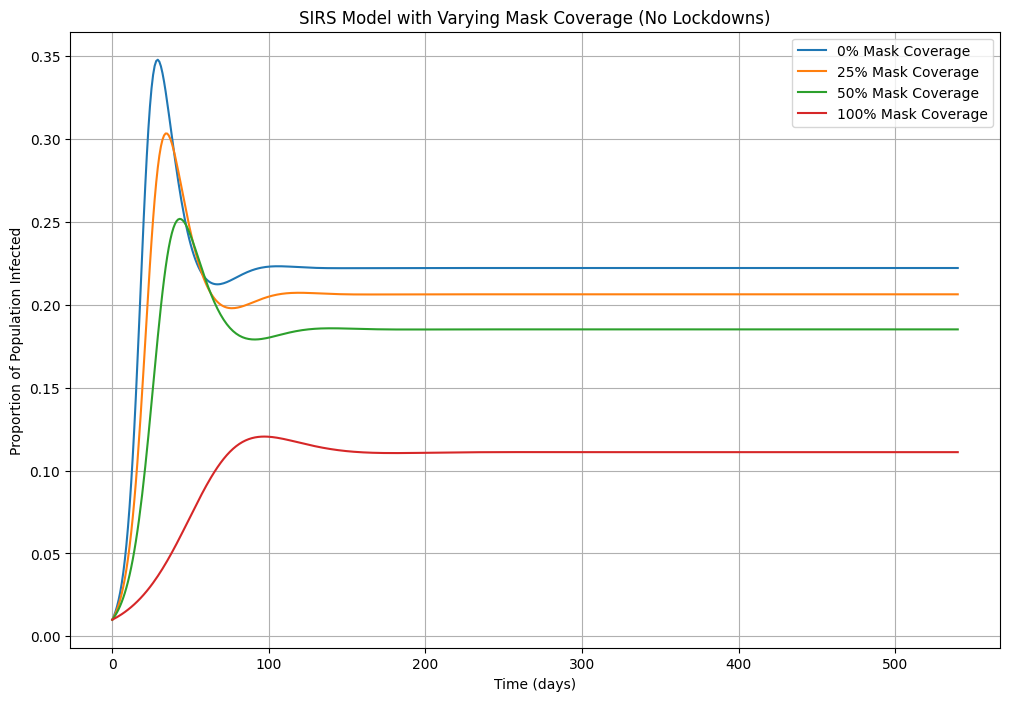

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

# Parameters
R0_base = 3.0               # Basic reproduction number without intervention
gamma = 0.1                 # Recovery rate
delta = 0.05                # Rate of immunity loss
mask_effectiveness = 0.5    # Masks reduce transmission by 50%
total_days = 540            # Total simulation period in days (18 months)

# Define mask-wearing population percentages
mask_coverage_percentages = [0, 0.25, 0.5, 1.0]

# Base infection rate (beta) calculated from R0 and gamma
beta_base = R0_base * gamma

# Time points (days)
t = np.linspace(0, total_days, total_days)

# SIRS model differential equations with time-dependent infection rate
def sirs_model(y, t, gamma, delta, mask_coverage):
    S, I, R = y
    # Adjust the infection rate based on mask coverage
    beta = beta_base * (1 - mask_coverage * mask_effectiveness)
    # SIRS equations
    dS_dt = -beta * S * I + delta * R      # Susceptible equation
    dI_dt = beta * S * I - gamma * I       # Infected equation
    dR_dt = gamma * I - delta * R          # Recovered equation
    return [dS_dt, dI_dt, dR_dt]

# Plotting setup
plt.figure(figsize=(12, 8))

# Run the model for each mask coverage percentage and plot results
for mask_coverage in mask_coverage_percentages:
    # Initial conditions for each run
    S0 = 0.99      # Initial susceptible fraction
    I0 = 0.01      # Initial infected fraction
    R0 = 0.0       # Initial recovered fraction
    initial_conditions = [S0, I0, R0]
    
    # Solve the differential equations
    solution = odeint(sirs_model, initial_conditions, t, args=(gamma, delta, mask_coverage))
    S, I, R = solution.T

    # Plot results for Infected
    plt.plot(t, I, label=f'{int(mask_coverage * 100)}% Mask Coverage')

# Finalize plot
plt.xlabel('Time (days)')
plt.ylabel('Proportion of Population Infected')
plt.title('SIRS Model with Varying Mask Coverage (No Lockdowns)')
plt.legend()
plt.grid(True)
plt.show()


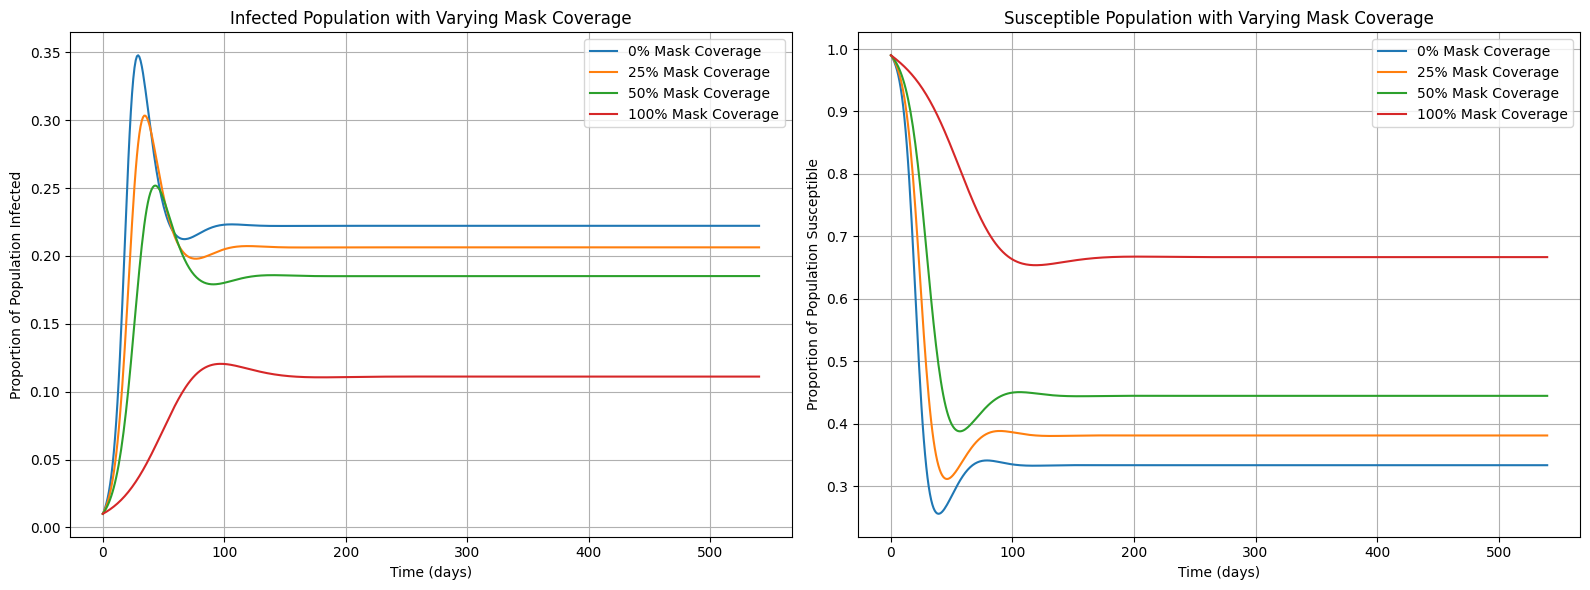

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

# Parameters
R0_base = 3.0               # Basic reproduction number without intervention
gamma = 0.1                 # Recovery rate
delta = 0.05                # Rate of immunity loss
mask_effectiveness = 0.5    # Masks reduce transmission by 50%
total_days = 540            # Total simulation period in days (18 months)

# Define mask-wearing population percentages
mask_coverage_percentages = [0, 0.25, 0.5, 1.0]

# Base infection rate (beta) calculated from R0 and gamma
beta_base = R0_base * gamma

# Time points (days)
t = np.linspace(0, total_days, total_days)

# SIRS model differential equations with time-dependent infection rate
def sirs_model(y, t, gamma, delta, mask_coverage):
    S, I, R = y
    # Adjust the infection rate based on mask coverage
    beta = beta_base * (1 - mask_coverage * mask_effectiveness)
    # SIRS equations
    dS_dt = -beta * S * I + delta * R      # Susceptible equation
    dI_dt = beta * S * I - gamma * I       # Infected equation
    dR_dt = gamma * I - delta * R          # Recovered equation
    return [dS_dt, dI_dt, dR_dt]

# Set up the figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Run the model for each mask coverage percentage and plot results
for mask_coverage in mask_coverage_percentages:
    # Initial conditions for each run
    S0 = 0.99      # Initial susceptible fraction
    I0 = 0.01      # Initial infected fraction
    R0 = 0.0       # Initial recovered fraction
    initial_conditions = [S0, I0, R0]
    
    # Solve the differential equations
    solution = odeint(sirs_model, initial_conditions, t, args=(gamma, delta, mask_coverage))
    S, I, R = solution.T

    # Plot results for Infected on the first subplot
    ax1.plot(t, I, label=f'{int(mask_coverage * 100)}% Mask Coverage')

    # Plot results for Susceptible on the second subplot
    ax2.plot(t, S, label=f'{int(mask_coverage * 100)}% Mask Coverage')

# Customize the infected subplot
ax1.set_xlabel('Time (days)')
ax1.set_ylabel('Proportion of Population Infected')
ax1.set_title('Infected Population with Varying Mask Coverage')
ax1.legend()
ax1.grid(True)

# Customize the susceptible subplot
ax2.set_xlabel('Time (days)')
ax2.set_ylabel('Proportion of Population Susceptible')
ax2.set_title('Susceptible Population with Varying Mask Coverage')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()


**Current ideas:**

- Find values to change beta values (maybe proportionally or using values from research) to mimic lockdowns / face mask wearing
- Read the two papers on GitHub
- Do the trends change when the population is taken into account?

## SEIR Model

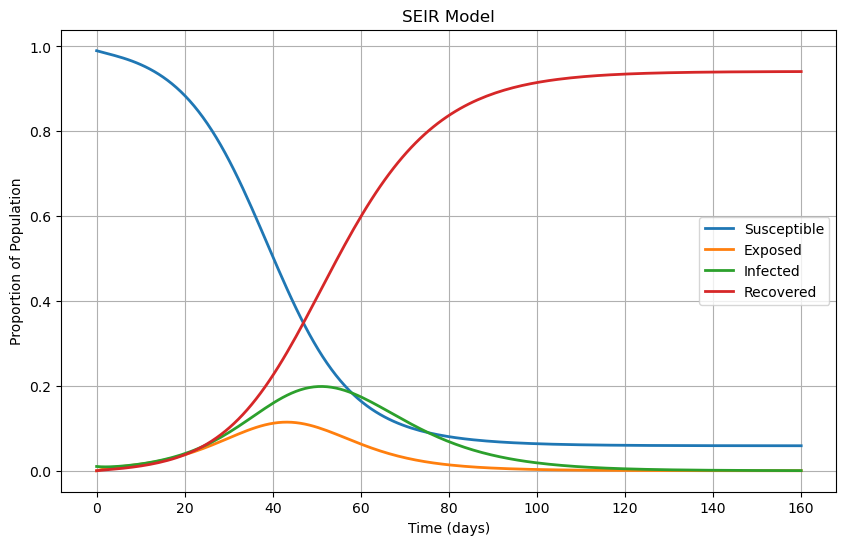

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

# Parameters
beta = 0.3   # Infection rate
sigma = 0.2  # Incubation rate (1/incubation period)
gamma = 0.1  # Recovery rate

# Initial conditions
S0 = 0.99     # Initial fraction of susceptible population
E0 = 0.0      # Initial fraction of exposed population
I0 = 0.01     # Initial fraction of infected population
R0 = 0.0      # Initial fraction of recovered population
initial_conditions = [S0, E0, I0, R0]

# Time points (days)
t = np.linspace(0, 160, 160)

# SEIR model differential equations
def seir_model(y, t, beta, sigma, gamma):
    S, E, I, R = y
    dS_dt = -beta * S * I              # Susceptible equation
    dE_dt = beta * S * I - sigma * E   # Exposed equation
    dI_dt = sigma * E - gamma * I      # Infected equation
    dR_dt = gamma * I                  # Recovered equation
    return [dS_dt, dE_dt, dI_dt, dR_dt]

# Solve the differential equations
solution = odeint(seir_model, initial_conditions, t, args=(beta, sigma, gamma))
S, E, I, R = solution.T

# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(t, S, label='Susceptible', linewidth=2)
plt.plot(t, E, label='Exposed', linewidth=2)
plt.plot(t, I, label='Infected', linewidth=2)
plt.plot(t, R, label='Recovered', linewidth=2)
plt.xlabel('Time (days)')
plt.ylabel('Proportion of Population')
plt.title('SEIR Model')
plt.legend()
plt.grid(True)
plt.show()
